In [126]:
import os
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf

from PIL import Image
from PIL import ImageOps

from scipy import ndimage
import matplotlib.patches as patches

In [127]:
model = tf.lite.Interpreter(model_path="model/model.tflite")
model.allocate_tensors()

In [128]:
input_details = model.get_input_details()
input_size = input_details[0]['shape'][2], input_details[0]['shape'][1]

In [129]:
def crop_image(image):
    cropped_image = None
    
    old_size = image.size
    desired_ratio = input_size[0] / input_size[1]
    old_ratio = old_size[0] / old_size[1]

    if old_ratio < desired_ratio:
        new_size = (old_size[0], int(old_size[0] / desired_ratio))
    else:
        new_size = (int(old_size[1] * desired_ratio), old_size[1])

    delta_w = new_size[0] - old_size[0]
    delta_h = new_size[1] - old_size[1]
    padding = (delta_w // 2, delta_h // 2, delta_w - (delta_w // 2), delta_h - (delta_h // 2))
    cropped_image = ImageOps.expand(image, padding)
    
    return cropped_image

In [130]:
def preprocess_image(cropped_image):
    image_for_prediction = None
    
    resized_image = cropped_image.resize(input_size, Image.BILINEAR)
    
    image_for_prediction = np.asarray(resized_image).astype(np.float32)
    image_for_prediction = np.expand_dims(image_for_prediction, 0)
    image_for_prediction = image_for_prediction / 127.5 - 1
    
    return image_for_prediction

In [131]:
def segment_image(image_for_prediction, cropped_image):
    segmentation_map = None
    
    model.set_tensor(input_details[0]['index'], image_for_prediction)
    model.invoke()
    
    output_details = model.get_output_details()
    output_data = model.get_tensor(output_details[0]['index'])
    
    width, height = cropped_image.size
    
    segmentation_map = tf.argmax(tf.image.resize(output_data, (height, width)), axis=3)
    segmentation_map = tf.squeeze(segmentation_map).numpy().astype(np.int8)
    
    condition = (segmentation_map == 0) | (segmentation_map == 1) | \
                (segmentation_map == 11) | (segmentation_map == 13)
    segmentation_map = np.where(condition, segmentation_map, 19)
    
    return segmentation_map

In [132]:
def create_cityscapes_label_colormap():
  colormap = np.zeros((256, 3), dtype=np.uint8)
  colormap[0] = [128, 64, 128]
  colormap[1] = [244, 35, 232]
  colormap[11] = [220, 20, 60]
  colormap[13] = [0, 0, 142]
  colormap[19] = [128, 128, 128]

  return colormap

In [133]:
def label_to_color_image(label):
  colormap = create_cityscapes_label_colormap()

  return colormap[label]

In [134]:
def visualize(image, segmentation_map, car_boxes, pedestrian_boxes):
  plt.figure(figsize=(15, 5))

  plt.subplot(1, 3, 1)
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(1, 3, 2)
  seg_image = label_to_color_image(segmentation_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(1, 3, 3)
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.5)
  plt.axis('off')
  plt.title('segmentation overlay')
  
  for box in car_boxes:
    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)

  for box in pedestrian_boxes:
    rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='y', facecolor='none')
    plt.gca().add_patch(rect)

  plt.grid('off')
  plt.show()

In [135]:
def extract_bounding_boxes(segmentation_map, class_id):
    mask = (segmentation_map == class_id).astype(np.uint8)
    labeled, num_features = ndimage.label(mask)
    boxes = []
    for region in range(1, num_features + 1):
        coords = np.column_stack(np.where(labeled == region))
        if coords.size == 0:
            continue
        y_min, x_min = coords.min(axis=0)
        y_max, x_max = coords.max(axis=0)
        boxes.append((x_min, y_min, x_max, y_max))
    return boxes

In [136]:
images_path = "data/"
images = [Image.open(images_path + image_name) for image_name in os.listdir(images_path)]

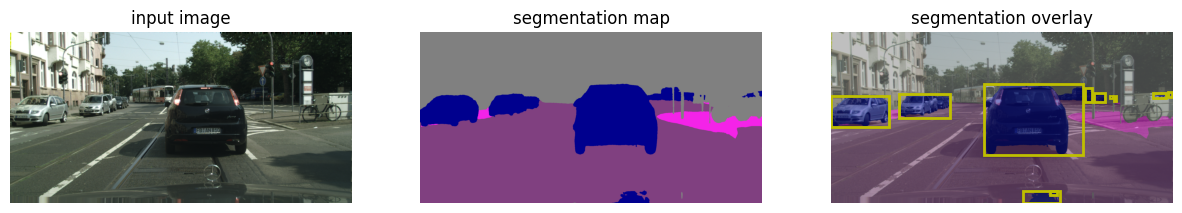

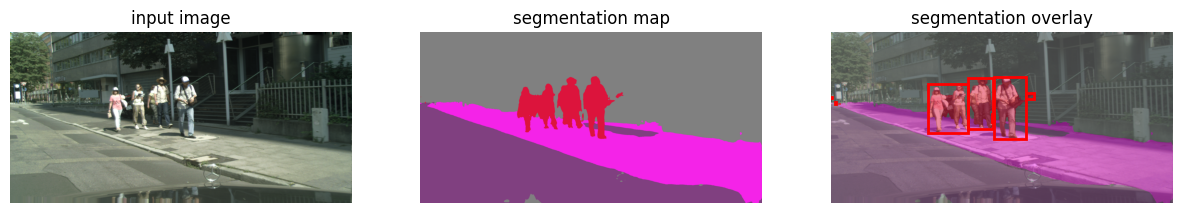

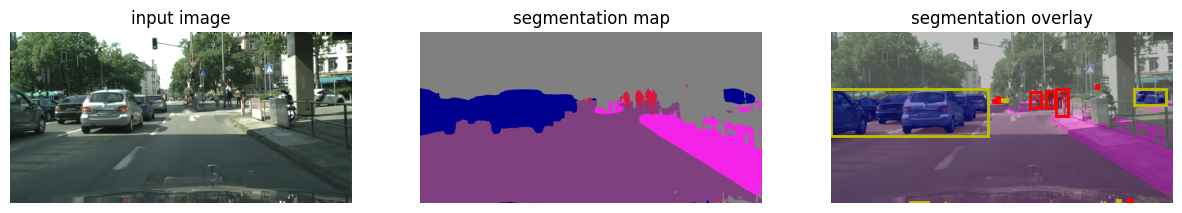

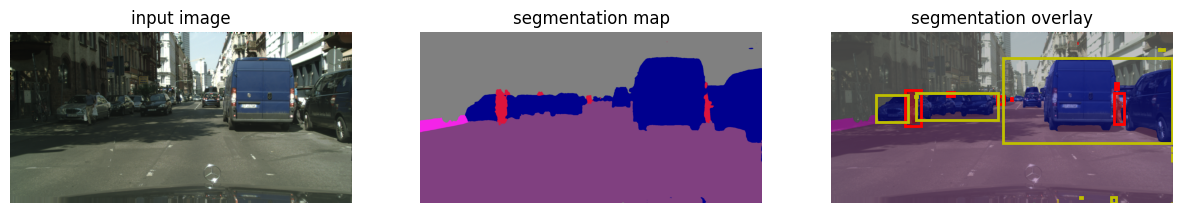

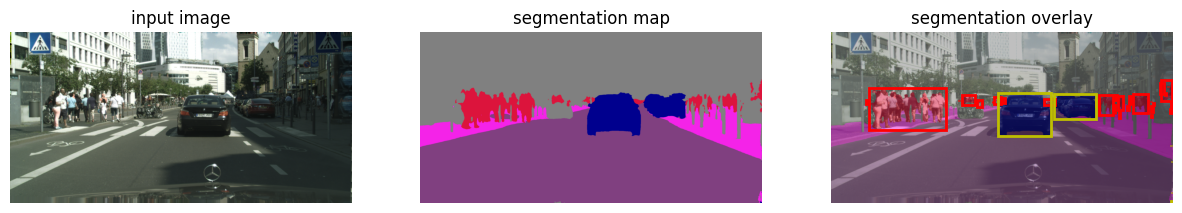

In [137]:
for image in images:
    cropped_image = crop_image(image)
    image_for_prediction = preprocess_image(cropped_image)
    segmentation_map = segment_image(image_for_prediction, cropped_image)
    
    car_boxes = extract_bounding_boxes(segmentation_map, 11)
    pedestrian_boxes = extract_bounding_boxes(segmentation_map, 13)
    
    visualize(cropped_image, segmentation_map, car_boxes, pedestrian_boxes)